In [1]:
import pandas as pd
import numpy as np
import pylab as plt
%matplotlib inline
from astropy.time import Time

In [2]:
def figsize(scale):
    fig_width_pt = 513.17 #469.755                  # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = fig_width*golden_mean              # height in inches
    fig_size = [2*fig_width,2*fig_height]
    return fig_size

import pylab as plt
#plt.rcParams.update(plt.rcParamsDefault)
params = {'backend': 'pdf',
        'axes.labelsize': 10,
        'lines.markersize': 4,
        'font.size': 10,
        'xtick.major.size':6,
        'xtick.minor.size':3,  
        'ytick.major.size':6,
        'ytick.minor.size':3,
        'xtick.major.width':0.5,
        'ytick.major.width':0.5,
        'xtick.minor.width':0.5,
        'ytick.minor.width':0.5,
        'lines.markeredgewidth':1,
        'axes.linewidth':1.2,
        'legend.fontsize': 7,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'savefig.dpi':200,
        'path.simplify':True,
        'font.family': 'serif',
        'font.serif':'Times',
        'text.latex.preamble': [r'\usepackage{amsmath}',r'\usepackage{amsbsy}',
                                r'\DeclareMathAlphabet{\mathcal}{OMS}{cmsy}{m}{n}'],
        'figure.figsize': figsize(1)}

plt.rcParams.update(params)

In [3]:
import sys
sys.path.append('../../')
from frb_periodicity.utils import get_phase

In [4]:
import json

In [5]:
with open('r3_data.json', 'r') as f:
    r3_data = json.load(f)

burst_dict = r3_data['bursts']
obs_duration_dict = r3_data['obs_duration']
obs_startmjds_dict = r3_data['obs_startmjds']

In [6]:
bursts = []
for k in burst_dict.keys():
    bursts = bursts + burst_dict[k]

obs_duration = []
for k in obs_duration_dict.keys():
    obs_duration = obs_duration + obs_duration_dict[k]

obs_startmjds = []
for k in obs_startmjds_dict.keys():
    obs_startmjds = obs_startmjds + obs_startmjds_dict[k]

In [7]:
bursts = np.array(bursts)
obs_duration = np.array(obs_duration)
obs_startmjds = np.array(obs_startmjds)

In [8]:
period = 16.35
nbins = 40

In [9]:
obs_start_phases = get_phase(obs_startmjds, period)
hist, bin_edges_obs = np.histogram(obs_start_phases, bins=nbins)

In [10]:
obs_start_phases_dict = {}
duration_per_phase_dict = {}
for k in obs_startmjds_dict.keys():
    obs_start_phases_dict[k] = get_phase(np.array(obs_startmjds_dict[k]), 
                                         period)
    durations = np.array(obs_duration_dict[k])
    start_phases = obs_start_phases_dict[k]
    
    d_hist = []
    for i in range(len(bin_edges_obs)):
        if i>0:
            d_hist.append(durations[(start_phases < bin_edges_obs[i]) & 
                                    (start_phases > bin_edges_obs[i-1])].sum())
            
    duration_per_phase_dict[k] = np.array(d_hist)/(60*60)

In [11]:
obs_duration = np.array(obs_duration)
duration_hist = []
for i in range(len(bin_edges_obs)):
    if i>0:
        duration_hist.append(obs_duration[(obs_start_phases < bin_edges_obs[i]) & 
                                          (obs_start_phases > bin_edges_obs[i-1])].sum())

duration_hist = np.array(duration_hist)/(60*60)

In [12]:
bin_mids = (bin_edges_obs[:-1] + bin_edges_obs[1:])/2

In [13]:
phase_lst = []
for k in burst_dict.keys():
    phase_lst.append(list(get_phase(np.array(burst_dict[k]), period)))

In [14]:
cm = plt.cm.get_cmap('tab20').colors

In [15]:
burst_hist_colors = [cm[0], cm[2], cm[4], cm[6], cm[8]]
obs_hist_colors = [cm[0], cm[1], cm[3], cm[5], cm[2], cm[4], cm[7], cm[9], cm[11], cm[6], cm[8]]

2020-06-03 12:20:35,963 - _findfont_cached -matplotlib.font_manager - WARNING - findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
2020-06-03 12:20:36,036 - _findfont_cached -matplotlib.font_manager - WARNING - findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


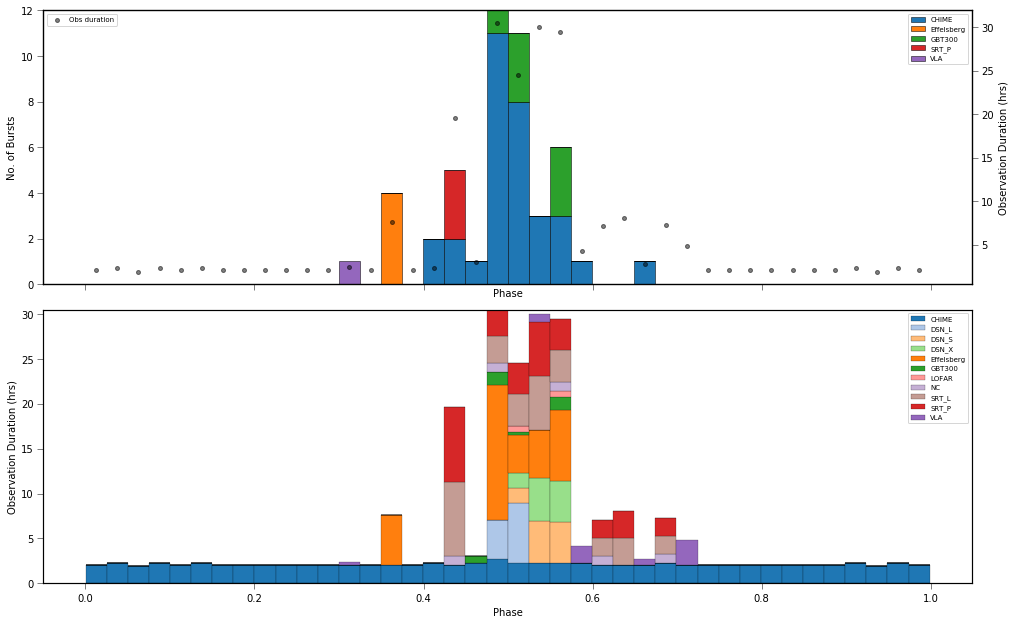

In [16]:
fig, ax = plt.subplots(2, 1, sharex=True)
ax1 = ax[0]
ax1_right = ax1.twinx()
ax1.hist(phase_lst, bins=bin_edges_obs, stacked=True, density=False, label=burst_dict.keys(), 
         edgecolor='black', linewidth=0.5, color=burst_hist_colors)

ax1.set_xlabel('Phase')
ax1.set_ylabel('No. of Bursts')

ax1_right.scatter(bin_mids, duration_hist, label='Obs duration', c='k', alpha=0.5)
ax1_right.set_ylabel('Observation Duration (hrs)')

ax1.legend()
ax1_right.legend(loc=2)

ax2 = ax[1]
cum_ds = np.zeros(nbins)
for i, k in enumerate(duration_per_phase_dict):
    d = duration_per_phase_dict[k]
    ax2.bar(bin_edges_obs[:-1], d, width=bin_edges_obs[1]-bin_edges_obs[0], align='edge', bottom=cum_ds, 
            alpha=1, label=k, edgecolor='black', linewidth=0.2, color=obs_hist_colors[i])

    cum_ds += d     
ax2.set_xlabel('Phase')
ax2.set_ylabel('Observation Duration (hrs)')
ax2.legend()

plt.tight_layout()
plt.savefig('R3_rnass_new.png', bbox_inches='tight')